In [1]:
from glob import glob
import pandas as pd

for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/comp_threaded.csv (194, 32)
competition_data/comp_adaptor.csv (25, 20)
competition_data/tube_end_form.csv (27, 2)
competition_data/comp_straight.csv (361, 12)
competition_data/comp_tee.csv (4, 14)
competition_data/comp_boss.csv (147, 15)
competition_data/components.csv (2048, 3)
competition_data/comp_float.csv (16, 7)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/comp_elbow.csv (178, 16)
competition_data/type_connection.csv (14, 2)
competition_data/train_set.csv (30213, 8)
competition_data/comp_sleeve.csv (50, 10)
competition_data/test_set.csv (30235, 8)
competition_data/tube.csv (21198, 16)
competition_data/comp_hfl.csv (6, 9)
competition_data/type_end_form.csv (8, 2)
competition_data/comp_other.csv (1001, 3)
competition_data/type_component.csv (29, 2)
competition_data/specs.csv (21198, 11)
competition_data/comp_nut.csv (65, 11)


In [4]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [5]:
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

In [8]:
trainval.head(20)

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561
5,TA-00002,S-0066,2013-07-07,0,0,Yes,50,3.224406
6,TA-00002,S-0066,2013-07-07,0,0,Yes,100,3.082521
7,TA-00002,S-0066,2013-07-07,0,0,Yes,250,2.999060
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983


In [10]:
trainval['quote_date'] = pd.to_datetime(trainval['quote_date'], infer_datetime_format=True)
test['quote_date'] = pd.to_datetime(test['quote_date'], infer_datetime_format=True)

In [11]:
trainval['quote_date'].describe()

count                   30213
unique                   1781
top       2013-10-01 00:00:00
freq                     2877
first     1982-09-22 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

In [12]:
test['quote_date'].describe()

count                   30235
unique                   1778
top       2013-09-01 00:00:00
freq                     2992
first     1985-11-16 00:00:00
last      2017-01-01 00:00:00
Name: quote_date, dtype: object

In [16]:
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()
len(trainval_tube_assemblies), len(test_tube_assemblies)

(8855, 8856)

In [17]:
trainval_tube_assemblies

array(['TA-00002', 'TA-00004', 'TA-00005', ..., 'TA-21195', 'TA-21196',
       'TA-21197'], dtype=object)

In [18]:
set(trainval_tube_assemblies) & set(test_tube_assemblies)

set()

In [20]:
# Train Test Split
from sklearn.model_selection import train_test_split
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)

In [21]:
len(train_tube_assemblies), len(val_tube_assemblies)

(6641, 2214)

In [22]:
set(train_tube_assemblies) & set(val_tube_assemblies)

set()

In [24]:
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]
train.shape, val.shape, trainval.shape

((22628, 8), (7585, 8), (30213, 8))

### Baselines

In [25]:
target = 'cost'
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value=y_train.mean())
print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))

Validation RMSLE, Mean Baseline: 0.9418101276064408


### Develop Model that Beats Baseline

In [26]:
features = ['quantity']
X_train = train[features]
X_val = val[features]
target = 'cost'
features = train.columns.drop([target, 'tube_assembly_id'])
X_train = train[features]
y_train = train[target]
X_test = test[features]

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
r2 = model.score(X_val, y_val)
print('Validation R^2:', r2)

Validation R^2: 0.08879518736792147


In [29]:
y_pred = model.predict(X_val)
print(f'Validation RMSLE, Random Forest with {features}')
print(rmsle(y_val, y_pred))

Validation RMSLE, Random Forest with ['quantity']
0.6908805822519186


### Log-Transofmr target variable

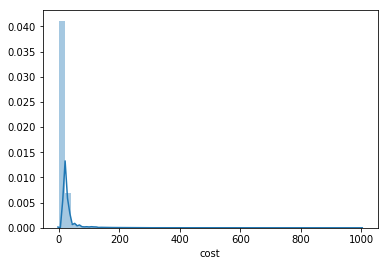

In [30]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [31]:
y_train_log = np.log1p(y_train)
y_train_log_exp = np.expm1(y_train_log)

In [32]:
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
rmsle(y_val, y_pred)

0.622925465880199

In [34]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [35]:
y_val_log = np.log1p(y_val)
rmse(y_val_log, y_pred_log)

0.622925465880199

In [38]:
train.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
8,TA-00004,S-0066,2013-07-07,0,0,Yes,1,21.972702
9,TA-00004,S-0066,2013-07-07,0,0,Yes,2,12.407983
10,TA-00004,S-0066,2013-07-07,0,0,Yes,5,6.668596
11,TA-00004,S-0066,2013-07-07,0,0,Yes,10,4.754539
12,TA-00004,S-0066,2013-07-07,0,0,Yes,25,3.608331


In [52]:
def wrangle(X): 
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    
    X = X.drop(columns='quote_date')
    
    X = X.drop(columns='tube_assembly_id')
    
    return X

In [53]:
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)

/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dwightchurchill/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [54]:
features = train_wrangled.columns.drop('cost')
print('Features:', features.tolist())

Features: ['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month']


In [55]:
X_train = train_wrangled[features]
X_val = val_wrangled[features]

In [56]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
rmse(y_val_log, y_pred_log)

0.39501769597010006

In [57]:
y_pred = np.expm1(y_pred_log)
rmsle(y_val, y_pred)

0.39501769597010006

### Feature Importance 

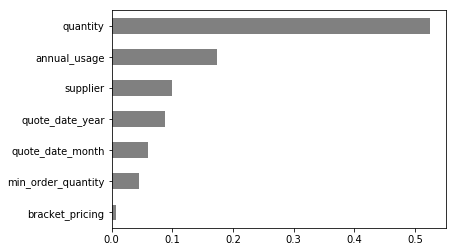

In [58]:
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

### Cross Validation

In [59]:
%%time
from sklearn.model_selection import cross_val_score

k = 3
groups = train['tube_assembly_id']
scores = cross_val_score(pipeline, X_train, y_train_log, cv=k,
                         scoring='neg_mean_squared_error', groups=groups)
print(f'RMSLE for {k} folds:', np.sqrt(-scores))

RMSLE for 3 folds: [0.41265705 0.42731689 0.4738954 ]
CPU times: user 1.05 s, sys: 357 ms, total: 1.41 s
Wall time: 4.85 s


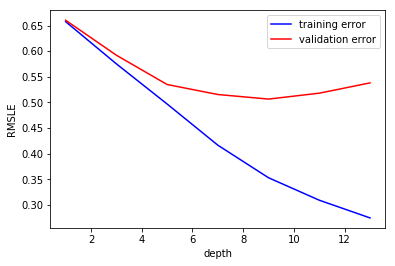

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor())

depth = range(1, 15, 2)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train_log,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_squared_error', 
    cv=2, groups=groups)

train_rmsle = np.sqrt(-train_scores)
val_rmsle = np.sqrt(-val_scores)
plt.plot(depth, np.mean(train_rmsle, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_rmsle, axis=1), color='red', label='validation error')
plt.xlabel('depth')
plt.ylabel('RMSLE')
plt.legend();

### Hyperparameter Optimization

In [61]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_features': uniform(),
    'randomforestregressor__min_samples_leaf': [1, 10, 100]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train_log, groups=groups)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   12.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   13.5s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.8s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
        handle_unknown='value', mapping=None, return_df=True, verbose=0)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto'...ors='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'randomforestregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1ab9eef0>, 'randomforestregressor__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1d21beb8>, 'randomforestregressor__min_samples_leaf': [1, 10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squ

In [62]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'randomforestregressor__max_features': 0.6463815471176737, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 368}
Cross-validation RMSLE 0.4465164440931351


### Now with XGBoost

In [63]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000),
    'xgbregressor__max_depth': randint(3, 7)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train_log, groups=groups)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   50.3s remaining:   50.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   51.3s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


[17:24:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
        handle_unknown='value', mapping=None, return_df=True, verbose=0)), ('xgbregressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytre...lpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1))]),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'xgbregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1d006cc0>, 'xgbregressor__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1dc41780>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=10)

In [64]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 527}
Cross-validation RMSLE 0.45663819156260377


In [65]:
results_df = pd.DataFrame(search.cv_results_)
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,29.719739,0.329640,1.888517,0.013505,5,926,"{'xgbregressor__max_depth': 5, 'xgbregressor__...",-0.184206,-0.246654,-0.215430,0.031224,4,-0.080244,-0.054102,-0.067173,0.013071
1,25.068092,0.128164,1.316809,0.069664,4,957,"{'xgbregressor__max_depth': 4, 'xgbregressor__...",-0.181795,-0.250681,-0.216238,0.034443,5,-0.099393,-0.065674,-0.082533,0.016860
2,20.138628,0.034328,1.086582,0.056937,6,534,"{'xgbregressor__max_depth': 6, 'xgbregressor__...",-0.182703,-0.241968,-0.212336,0.029633,2,-0.077800,-0.052437,-0.065118,0.012681
3,16.383640,0.096328,0.911238,0.037830,5,527,"{'xgbregressor__max_depth': 5, 'xgbregressor__...",-0.180032,-0.237005,-0.208518,0.028487,1,-0.092389,-0.061034,-0.076711,0.015678
4,33.947456,0.204850,2.970593,0.113793,6,646,"{'xgbregressor__max_depth': 6, 'xgbregressor__...",-0.184488,-0.245051,-0.214770,0.030281,3,-0.074060,-0.050618,-0.062339,0.011721


In [66]:
results_df.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
3,16.383640,0.096328,0.911238,0.037830,5,527,"{'xgbregressor__max_depth': 5, 'xgbregressor__...",-0.180032,-0.237005,-0.208518,0.028487,1,-0.092389,-0.061034,-0.076711,0.015678
2,20.138628,0.034328,1.086582,0.056937,6,534,"{'xgbregressor__max_depth': 6, 'xgbregressor__...",-0.182703,-0.241968,-0.212336,0.029633,2,-0.077800,-0.052437,-0.065118,0.012681
4,33.947456,0.204850,2.970593,0.113793,6,646,"{'xgbregressor__max_depth': 6, 'xgbregressor__...",-0.184488,-0.245051,-0.214770,0.030281,3,-0.074060,-0.050618,-0.062339,0.011721
0,29.719739,0.329640,1.888517,0.013505,5,926,"{'xgbregressor__max_depth': 5, 'xgbregressor__...",-0.184206,-0.246654,-0.215430,0.031224,4,-0.080244,-0.054102,-0.067173,0.013071
1,25.068092,0.128164,1.316809,0.069664,4,957,"{'xgbregressor__max_depth': 4, 'xgbregressor__...",-0.181795,-0.250681,-0.216238,0.034443,5,-0.099393,-0.065674,-0.082533,0.016860


In [67]:
pipeline = search.best_estimator_
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
submission = pd.read_csv('sample_submission.csv')
submission['cost'] = y_pred
submission.to_csv('submission.csv', index=False)

NameError: name 'X_test' is not defined